In [3]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliBandit:

    def __init__(self,K):
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
np.random.seed(42)
K=10
banit_10_arm = BernoulliBandit(K)
print(banit_10_arm.probs)
print(f'随机生成了{K}个老虎机')
print(f'最大概率为{banit_10_arm.best_idx}编号{banit_10_arm.best_prob}')


[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]
随机生成了10个老虎机
最大概率为1编号0.9507143064099162


In [4]:
np.random.seed(42)
a = np.random.uniform(size=2)
id = np.argmax(a)
print(id)
print(a)
print(a[id])

1
[0.37454012 0.95071431]
0.9507143064099162


In [5]:
class Solver():
    def __init__(self,bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0.
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)


    def run_one_step(self):

        raise NotImplementedError
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)


In [6]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01,init_prob=1.0):
        super(EpsilonGreedy,self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob]*self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0,self.bandit.K)
        else:
           k = np.argmax(self.estimates)
        
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k]+1)*(r-self.estimates[k])
        return k  



31.43605891746862


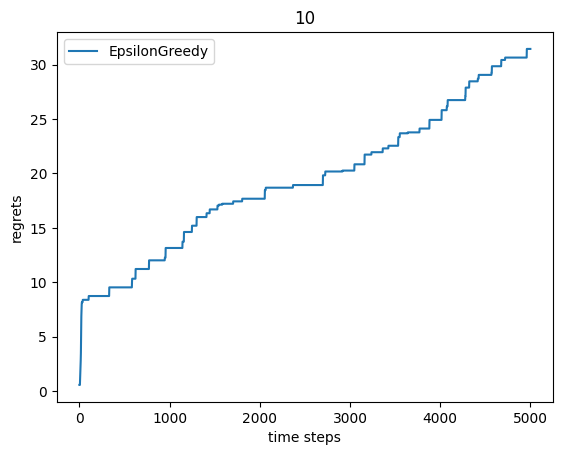

In [7]:
def plot_results(solvers,solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list,solver.regrets,label=solver_names[idx])

    plt.xlabel('time steps')
    plt.ylabel('regrets')
    plt.title(solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(42)
epsilon_g = EpsilonGreedy(banit_10_arm,epsilon=0.01)
epsilon_g.run(5000)
print(epsilon_g.regret)
plot_results([epsilon_g],['EpsilonGreedy'])

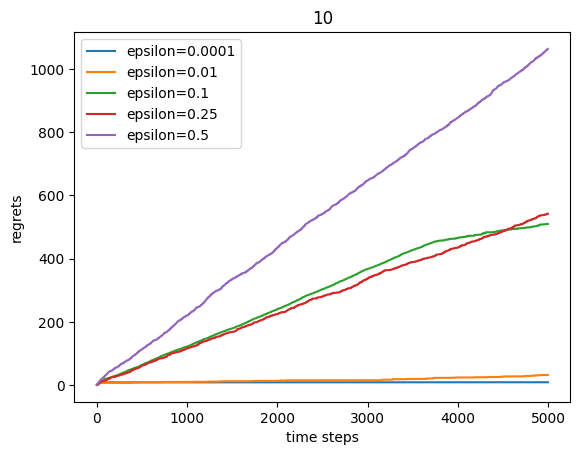

In [8]:
import numpy as np

np.random.seed(42)
epsilons = [1e-4,0.01, 0.1, 0.25,0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(banit_10_arm,epsilon=e) for e in epsilons]
epsilon_greedy_solver_name = ['epsilon={}'.format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list,epsilon_greedy_solver_name)

8.498280976556856


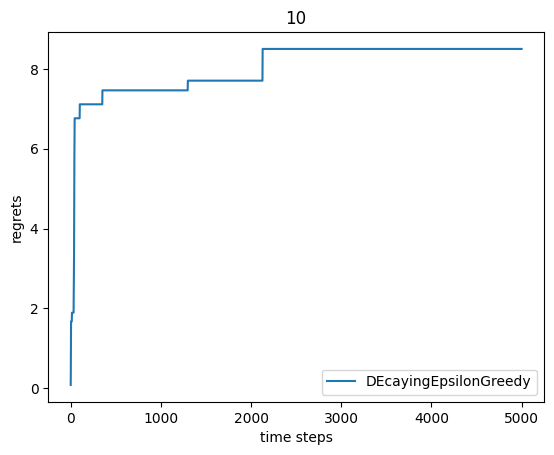

In [9]:
class DecayingEpsilonGreedy(Solver):
    #随着时间减小的epsilon
    def __init__(self,bandit,init_prob=1.0):
        super(DecayingEpsilonGreedy,self).__init__(bandit)
        self.estimates = np.array([init_prob]*self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:
            k = np.random.randint(0,self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k]+1)*(r-self.estimates[k])

        return k

np.random.seed(42)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(banit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print(decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver],['DEcayingEpsilonGreedy'])


89.66870876881895


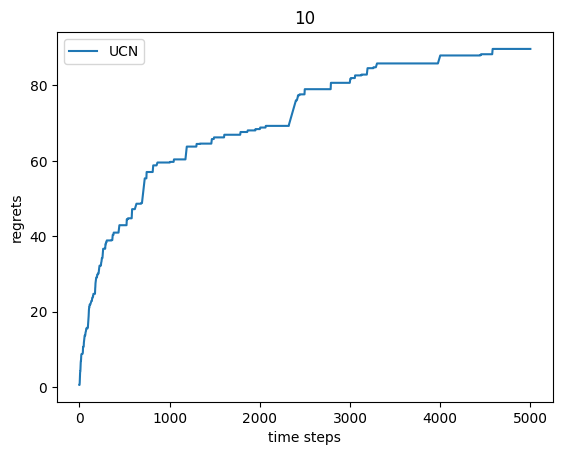

In [10]:
#上置信算法 随着一个动作被尝试的次数的增加而减小
class UCB(Solver):
    def __init__(self, bandit,coef, init_prob=1.0):
        super(UCB,self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob]*self.bandit.K)
        self.coef = coef
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count)/(2*(self.counts+1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k]+1)*(r-self.estimates[k])

        return k
coef = 1
UCB_solver = UCB(banit_10_arm,coef)
UCB_solver.run(5000)
print(UCB_solver.regret)
plot_results([UCB_solver],['UCN'])